<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [SYNOP2] - First predictions at 3h
<!-- DESC --> Episode 2 : Learning session and weather prediction attempt at 3h
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Make a simple prediction (3h)
 - Understanding the use of a recurrent neural network


SYNOP meteorological data, available at: https://public.opendatasoft.com

## What we're going to do :

 - Read our dataset
 - Select our data and normalize it
 - Doing our training
 - Making simple predictions

## Step 1 - Import and init
### 1.1 - Python

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import math, random
from math import sin,cos,pi
import matplotlib.pyplot as plt

import pandas as pd
import h5py, json
import os,time,sys

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('SYNOP2')

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.17
Notebook id          : SYNOP2
Run time             : Saturday 06 March 2021, 09:53:24
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /home/pjluc/datasets/fidle
Run dir              : ./run
Update keras cache   : False


### 1.2 - Parameters

In [481]:
# ---- About dataset
#
max_t      = 100
delta_t    = 0.01


sequence_len = 40
predict_len  = 10
features_len = 2

# ---- About training
#
scale            = 1        # Percentage of dataset to be used (1=all)
train_prop       = .8       # Percentage for train (the rest being for the test)
batch_size       = 32
epochs           = 10

Override parameters (batch mode) - Just forget this cell

In [475]:
pwk.override('scale', 'train_prop', 'sequence_len', 'batch_size', 'epochs')

## Step 2 - Generation of a fun dataset
### 2.1 - Moving our ladybug

In [476]:
def lady_move(t):
    
    # ---- Init parameters (first time)
    #
    if t==0:
        lady_move.params_x=[ random.gauss(.2,.5) for u in range(8)]
        lady_move.params_y=[ random.gauss(.2,.5) for u in range(8)]

    # --- Retrieve parameters
    #
    [ax1, ax2, ax3, ax4, kx1, kx2, kx3, kx4] = lady_move.params_x
    [ay1, ay2, ay3, ay4, ky1, ky2, ky3, ky4] = lady_move.params_y
    
    dx = ( ax1*sin(t*pi/kx1) + ax2*cos(t*pi/kx2) + ax3*sin(t*pi/kx3) + ax4*cos(t*pi/kx4) )/20
    dy = ( ay1*sin(t*pi/ky1) + ay2*cos(t*pi/ky2) + ay3*sin(t*pi/ky3) + ay4*cos(t*pi/ky4) )/20
    return dx,dy

### 2.2 - Get some positions, and build dataset

In [477]:
# ---- Get positions
#
x,y = 0,0
positions=[]
for t in np.arange(0., max_t, delta_t):
    positions.append([x,y])
    dx,dy = lady_move(t)
    (x,y) = (x+dx, y+dy)

# ---- Build dataset
#
dataset = np.array(positions)

k = int(len(dataset)*train_prop)
x_train = dataset[:k]
x_test  = dataset[k:]

# ---- Normalize
#
mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

print("Train shape is : ", x_train.shape)
print("Test  shape is : ", x_test.shape)


Train shape is :  (8000, 2)
Test  shape is :  (2000, 2)


### 2.3 - Have a look

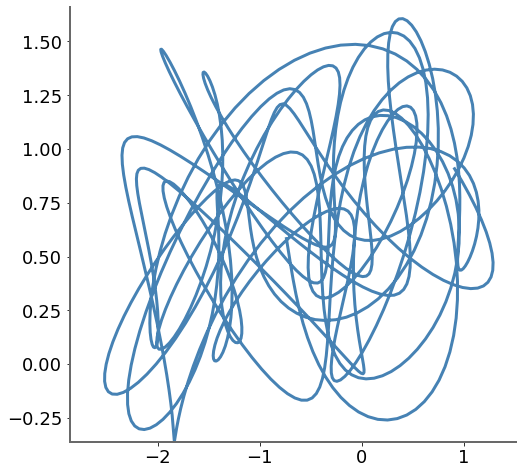

In [478]:
x,y=x_train[:1000,0],x_train[:1000,1]
x1,y1= x_train.min(axis=0)
x2,y2= x_train.max(axis=0)

fig = plt.figure(figsize=(8,8))

ax = plt.axes()
ax.plot(x, y, '-')
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
plt.show()

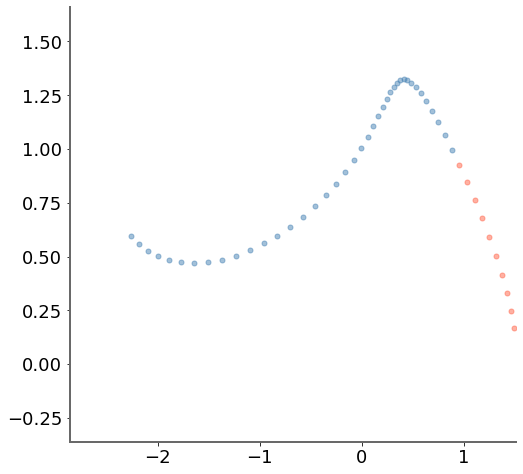

In [479]:
k1,k2 = sequence_len, predict_len
i = random.randint(0,len(x_test)-k1-k2)
j=i+k1

x,y=x_test[i:i+k1,0],x_test[i:i+k1,1]
u,v=x_test[j:j+k2,0],x_test[j:j+k2,1]

fig = plt.figure(figsize=(8,8))

ax = plt.axes()
ax.plot(x, y,'.', alpha=0.5)
ax.plot(u, v,'.', alpha=0.5)
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
plt.show()

### 2.2 - Prepare data generator

In [480]:
# ---- Train generator
train_generator = TimeseriesGenerator(x_train, x_train, length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(x_test,  x_test,  length=sequence_len,  batch_size=batch_size)

# ---- About

pwk.subtitle('About the splitting of our dataset :')

x,y=train_generator[0]
print(f'Nombre de train batchs disponibles : ', len(train_generator))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)

x,y=train_generator[0]
pwk.subtitle('What a batch looks like (x) :')
pwk.np_print(x[0] )
pwk.subtitle('What a batch looks like (y) :')
pwk.np_print(y[0])

<br>**About the splitting of our dataset :**

Nombre de train batchs disponibles :  249
batch x shape :  (32, 40, 2)
batch y shape :  (32, 2)


<br>**What a batch looks like (x) :**

[[ 0.908  0.908]
 [ 0.984  0.848]
 [ 1.054  0.787]
 [ 1.117  0.728]
 [ 1.172  0.67 ]
 [ 1.218  0.615]
 [ 1.253  0.563]
 [ 1.276  0.516]
 [ 1.286  0.473]
 [ 1.283  0.436]
 [ 1.266  0.405]
 [ 1.235  0.381]
 [ 1.192  0.364]
 [ 1.135  0.354]
 [ 1.067  0.351]
 [ 0.987  0.356]
 [ 0.898  0.369]
 [ 0.8    0.39 ]
 [ 0.696  0.417]
 [ 0.587  0.451]
 [ 0.475  0.492]
 [ 0.36   0.538]
 [ 0.246  0.589]
 [ 0.134  0.644]
 [ 0.025  0.701]
 [-0.079  0.761]
 [-0.178  0.821]
 [-0.27   0.881]
 [-0.355  0.939]
 [-0.432  0.994]
 [-0.501  1.045]
 [-0.562  1.091]
 [-0.616  1.131]
 [-0.663  1.164]
 [-0.704  1.188]
 [-0.74   1.204]
 [-0.772  1.21 ]
 [-0.801  1.207]
 [-0.829  1.193]
 [-0.857  1.17 ]]


<br>**What a batch looks like (y) :**

[-0.886  1.137]


## Step 3 - Create a model

In [482]:
model = keras.models.Sequential()
model.add( keras.layers.InputLayer(input_shape=(sequence_len, features_len)) )
model.add( keras.layers.LSTM(100, activation='relu') )
model.add( keras.layers.Dropout(0.2) )
model.add( keras.layers.Dense(features_len) )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               41200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 41,402
Trainable params: 41,402
Non-trainable params: 0
_________________________________________________________________


# Step 4 - Compile and run

### 4.1 - Callback

In [483]:
pwk.mkdir('./run/models')
save_dir = './run/models/best_model.h5'
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 4.2 - Compile

In [484]:
model.compile(optimizer='adam', 
              loss='mse', 
              metrics   = ['mae'] )

### 4.3 - Fit
6' with a CPU (laptop)  
2' with a GPU

In [485]:
pwk.chrono_start()

history=model.fit(train_generator, 
                  epochs=epochs, 
                  verbose=1,
                  validation_data = test_generator,
                  callbacks = [bestmodel_callback])

pwk.chrono_show()

Epoch 1/10
249/249 [==============================] - 8s 34ms/step - loss: 0.1236 - mae: 0.2570 - val_loss: 0.0126 - val_mae: 0.0924
Epoch 2/10
249/249 [==============================] - 8s 33ms/step - loss: 0.0247 - mae: 0.1219 - val_loss: 0.0058 - val_mae: 0.0628
Epoch 3/10
249/249 [==============================] - 8s 32ms/step - loss: 0.0174 - mae: 0.1010 - val_loss: 0.0046 - val_mae: 0.0561
Epoch 4/10
249/249 [==============================] - 8s 32ms/step - loss: 0.0150 - mae: 0.0926 - val_loss: 0.0036 - val_mae: 0.0469
Epoch 5/10
249/249 [==============================] - 8s 33ms/step - loss: 0.0142 - mae: 0.0895 - val_loss: 0.0033 - val_mae: 0.0462
Epoch 6/10
249/249 [==============================] - 9s 34ms/step - loss: 0.0130 - mae: 0.0859 - val_loss: 0.0018 - val_mae: 0.0343
Epoch 7/10
249/249 [==============================] - 9s 34ms/step - loss: 0.0126 - mae: 0.0844 - val_loss: 0.0022 - val_mae: 0.0368
Epoch 8/10
249/249 [==============================] - 9s 34ms/step - 

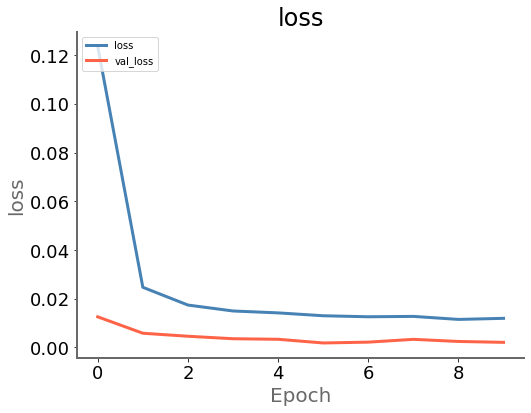

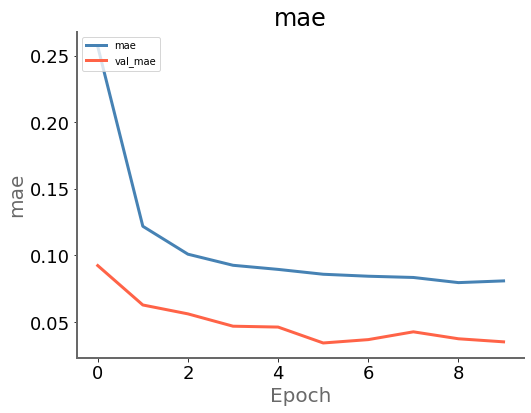

In [486]:
pwk.plot_history(history,plot={'loss':['loss','val_loss'], 'mae':['mae','val_mae']}, save_as='01-history')

## Step 5 - Predict

### 5.1 - Load model

In [487]:
loaded_model = tf.keras.models.load_model('./run/models/best_model.h5')

### 5.2 Make a prediction
A basic prediction, with normalized values (so humanly not very understandable)

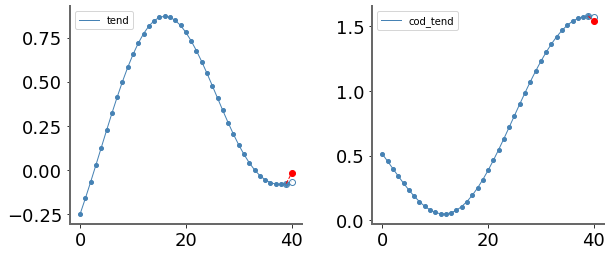

In [503]:
s=random.randint(0,len(x_test)-sequence_len)

sequence      = x_test[s:s+sequence_len]
sequence_true = x_test[s:s+sequence_len+1]

pred = loaded_model.predict( np.array([sequence]) )

# ---- Show result
pwk.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-prediction-norm')


### 5.3 Real prediction
We are now going to make a true prediction, with an un-normalized result

In [ ]:
def denormalize(mean,std,seq):
    nseq = seq.copy()
    for i,s in enumerate(nseq):
        s = s*std + mean
        nseq[i]=s
    return nseq


# ---- Get a sequence

i=random.randint(0,len(x_test)-sequence_len)
sequence      = x_test[i:i+sequence_len]
sequence_true = x_test[i:i+sequence_len+1]

# ---- Prediction

pred = loaded_model.predict( np.array([sequence]) )

# ---- De-normalization

sequence_true = denormalize(mean,std, sequence_true)
pred          = denormalize(mean,std, pred)

# ---- Show it
feat=11

pwk.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, only_features=[feat],width=14, height=8, save_as='03-prediction')

delta_deg=abs(sequence_true[-1][feat]-pred[-1][feat])
print(f'Gap between prediction and reality : {delta_deg:.2f} °C')


In [ ]:
pwk.end()

---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>